In [1]:
%%capture
!uv pip install s3fs zarr ctime fsspec rioxarray

*Workshop 4. Doing research with hydrological data*


# Practical 1: Uncertainty in rainfall estimates

## Contents
- Load in rain gauge and grid data
- Remove rain gauge data from dodgy gauges
- Compare estimations of events, and the differences


## Objectives:
- To understand how we can format data from different sources
- To determine the uncertainties in rainfall estimates between gridded rainfall and rain gauge data


# Introduction
Rainfall is famously difficult to measure/observe. But the best appraoches we currently use are rain gauges, rain radar. Satelitte-derived precipitation is much less accurate  

[Map of UK Gauge station]  

Also, a basic [interactive map](https://thomasjkeel.github.io/UK-Rain-Gauge-Network/gauges.html)  

We will be using the CEH-GEAR dataset for UK rainfall, but there is also the HadUK-Grid (link), which is more common, but uses a more uncertain spatial interpolation method.

> *Gridded rainfall products provide a best guess estimate of rainfall*

[image of gridding]  



### BASED ON: https://github.com/NERC-CEH/FDRI-comparing-rainfall-data-in-upper-severn

In [2]:
# Load required libraries
import fsspec
import zarr

import geopandas as gpd
import polars as pl
import xarray as xr
import rioxarray

import matplotlib.pyplot as plt

import data_utils

In [10]:
SEVERN_NORTHING_RANGE = [270000, 350000]
SEVERN_EASTING_RANGE = [279100, 390000]

# 1. Load data

**Data sources:**
- rain gauge and gridded rainfall data - from JASMIN object-store

## 1.1 Load CEH-GEAR (gridded rainfall data)

In [3]:
fdri_fs = fsspec.filesystem("s3", asynchronous=True, anon=True, endpoint_url="https://fdri-o.s3-ext.jc.rl.ac.uk")
gear_daily_zstore = zarr.storage.FsspecStore(fdri_fs, path="geardaily/GB/geardaily_fulloutput_yearly_100km_chunks.zarr")
gear_daily = xr.open_zarr(gear_daily_zstore, decode_times=True, decode_cf=True)
gear_daily # 310 GB

<xarray.Dataset> Size: 666GB
Dimensions:          (y: 1251, x: 701, time: 47481)
Coordinates:
    crs              int16 2B ...
    lat              (y, x) float64 7MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon              (y, x) float64 7MB dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time             (time) datetime64[ns] 380kB 1890-01-01 ... 2019-12-31
  * x                (x) float64 6kB 0.0 1e+03 2e+03 ... 6.98e+05 6.99e+05 7e+05
  * y                (y) float64 10kB 1.25e+06 1.249e+06 1.248e+06 ... 1e+03 0.0
Data variables:
    min_dist         (time, y, x) float64 333GB dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    rainfall_amount  (time, y, x) float64 333GB dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
Attributes: (12/21)
    Conventions:         CF-1.6
    comment:             In line with standard UK convention, the rainfall on...
    creator_email:       malngu@ceh.ac.uk, vke@ceh.ac.uk
    creator_name:        Maliko Tanguy, Virginie Keller
    creator_url:         
    date_issued:         2014-01-06
    ...                  ...
    publisher_email:     enquiries@ceh.ac.uk
    publisher_name:      Centre for Ecology and Hydrology
    publisher_url:       http://www.ceh.ac.uk
    reference:           Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, J...
    source:              CEH - GEAR: dataset created using Natural Neighbour ...
    version_comment:     The version number of each data file corresponds to ...

(270000.0, 350000.0)

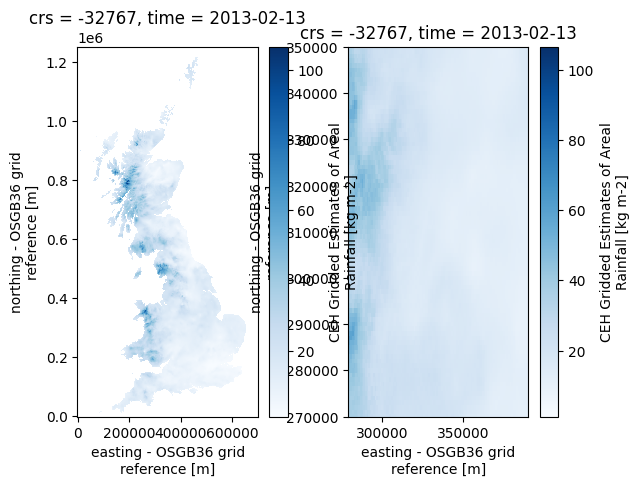

In [44]:
# plot data
fig, axes = plt.subplots(1, 2)
gear_daily.sel(time="2013-02-13")['rainfall_amount'].plot(ax=axes[0], cmap='Blues')
gear_daily.sel(time="2013-02-13")['rainfall_amount'].plot(ax=axes[1], cmap='Blues')
axes[1].set_xlim(SEVERN_EASTING_RANGE)
axes[1].set_ylim(SEVERN_NORTHING_RANGE)


## 1.2 Load daily rain gauge data

In [23]:
severn_rain_gauge_data = pl.read_csv('s3://rain-gauge/hourly_severn_rain_gauge_data.csv', storage_options={'endpoint_url': "https://fdri-o.s3-ext.jc.rl.ac.uk", 'anon': True}, try_parse_dates=True)
severn_rain_gauge_metadata = pl.read_csv('s3://rain-gauge/hourly_severn_rain_gauge_metadata.csv', storage_options={'endpoint_url': "https://fdri-o.s3-ext.jc.rl.ac.uk", 'anon': True})

In [28]:
severn_rain_gauge_data.head()

ID,DATETIME,PRECIPITATION
i64,datetime[μs],f64
89714,1978-10-01 00:00:00,0.0
89714,1978-10-02 00:00:00,2.0
89714,1978-10-03 00:00:00,0.0
89714,1978-10-04 00:00:00,0.0
89714,1978-10-05 00:00:00,0.0


In [6]:
severn_rain_gauge_metadata.head()

ID,SRC_ID,NAME,COUNTRY_CODE,EASTING,NORTHING,HYDROMETRIC_AREA,ELEVATION,GEOG_PATH
i64,i64,str,str,i64,i64,i64,i64,str
89714,2913,"""STRONGFORD W WKS""","""GB-GBN""",387932,339157,28,95,"""/BI/UK/GB/ENG/STS/"""
90358,2918,"""SUGNALL HALL""","""GB-GBN""",379831,331185,28,143,"""/BI/UK/GB/ENG/STS/"""
90359,2919,"""ECCLESHALL, SUGNALL HALL""","""GB-GBN""",379800,331200,28,137,"""/BI/UK/GB/ENG/STS/"""
90492,2920,"""WALTON HALL GARDENS""","""GB-GBN""",384900,328500,28,99,"""/BI/UK/GB/ENG/STS/"""
90537,2921,"""WHITMORE P STA""","""GB-GBN""",379900,340100,28,121,"""/BI/UK/GB/ENG/CHS/"""


In [25]:
severn_rain_gauge_data.filter(pl.col("ID") == 90537)["PRECIPITATION"]

PRECIPITATION
f64
2.0
5.1
1.5
0.0
10.9
…
7.3
0.1
0.0


#### 🤨 Task: how would you 

???
Replace the ??? below with your answer

*Hint: you can use the .filter method like above*

In [ ]:
severn_rain_gauge_metadata.???

## 1.3 Load spatial datasets for Upper Severn catchment
Data originally downloaded from: https://nrfa.ceh.ac.uk/data/search

In [7]:
%%capture
# !wget -O https://github.com/Thomasjkeel/UKCEH_Summer_School_2025/blob/edit/workshop-3/Workshop_4/severn_catchment_data.tar.gz
!mkdir -p severn_catchment_data 
!tar -xvf severn_catchment_data.tar.gz -C severn_catchment_data

In [21]:
# Greater Severn catchment boundary
bewdley_shp = gpd.read_file('severn_catchment_data/Bewdley/54001/54001.shp')

# Upper Severn catchment boundaries
abermule_shp = gpd.read_file('severn_catchment_data/Abermule/54014/54014.shp')
dolwen_shp = gpd.read_file('severn_catchment_data/Dolwen/54080/54080.shp')
plynlimon_shp = gpd.read_file('severn_catchment_data/Plynlimon Flume/54022/54022.shp')

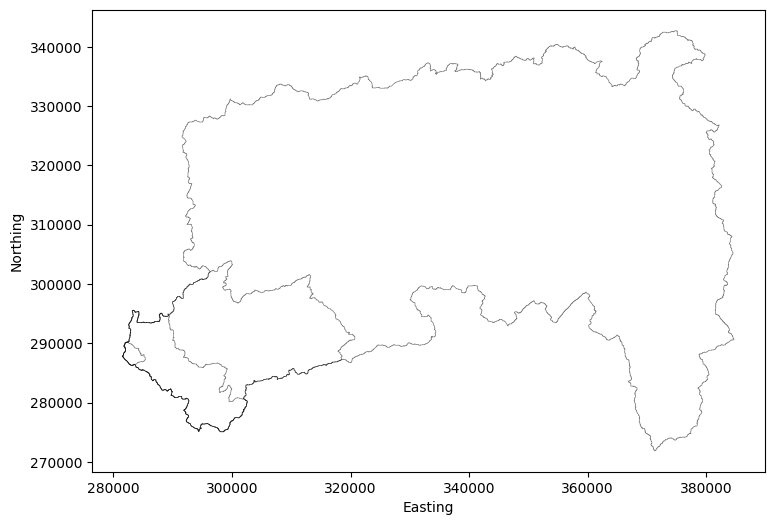

In [22]:
fig, ax = plt.subplots(1, figsize=(12, 6), sharex=True, sharey=True)
ax.set_xlabel('Easting'); ax.set_ylabel('Northing');
abermule_shp.plot(ax=ax, facecolor='none', alpha=.5, linewidth=.5)
bewdley_shp.plot(ax=ax, facecolor='none', alpha=.5, linewidth=.5)
dolwen_shp.plot(ax=ax, facecolor='none', alpha=.5, linewidth=.5)
plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5, linewidth=.5)
plt.subplots_adjust(hspace=.2)

In [11]:
severn_hght = rioxarray.open_rasterio('severn_catchment_data/HGHT_SEVERN_1km.tif')
severn_hght = severn_hght.sortby('y')
severn_hght = severn_hght.sel(band=1)

severn_hght = severn_hght.sel(x=slice(*SEVERN_EASTING_RANGE), y=slice(*SEVERN_NORTHING_RANGE))

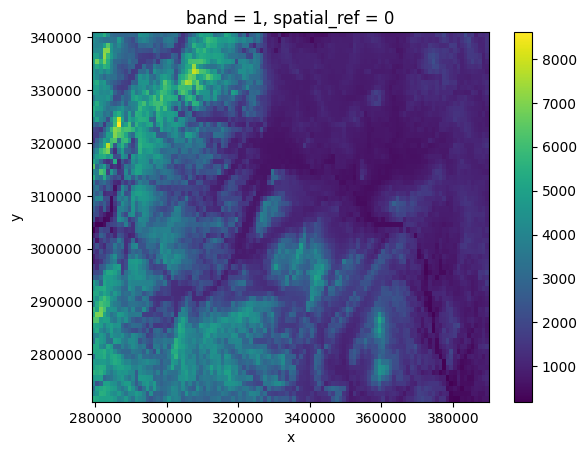

In [13]:
severn_hght.plot()

# 2. Format the data
Most of data science is about data cleaning and formatting. This is especially true for those using environmental data

### 2.1 Quality controlling rain gauge dataset
Data from the rain gauge data is not Quality-controlled


In [7]:
# severn_rain_gauge_data.loc[severn_rain_gauge_data["ID"] == 90537]

In [8]:
one_gauge = severn_rain_gauge_data.filter(pl.col("ID") == 90537)

In [9]:
one_gauge_monthly_sums = one_gauge.group_by_dynamic('DATETIME', every='1m').agg(pl.col('PRECIPITATION').mean())

In [10]:
one_gauge_monthly_sums

DATETIME,PRECIPITATION
datetime[μs],f64
1961-01-01 00:00:00,2.0
1961-01-02 00:00:00,5.1
1961-01-03 00:00:00,1.5
1961-01-04 00:00:00,0.0
1961-01-05 00:00:00,10.9
…,…
1989-03-27 00:00:00,7.3
1989-03-28 00:00:00,0.1
1989-03-29 00:00:00,0.0


#### 🤨 Tasks

???
Replace the ??? below with your answer

# Format spatial data

We have data

In [14]:
def mask_region_rainfall(rainfall_data, region_mask):
    return rainfall_data * data_utils.binarize_hght_clip(region_mask).data


def mask_region_rainfall_by_hght(rainfall_data, region_hght, threshold):
    region_hght_mask = region_hght/region_hght.where(region_hght > threshold)
    return rainfall_data * region_hght_mask.data



In [17]:
gear_daily.sel(x=slice(*SEVERN_EASTING_RANGE), y=slice(*SEVERN_NORTHING_RANGE))

<xarray.Dataset> Size: 381kB
Dimensions:          (y: 0, x: 111, time: 47481)
Coordinates:
    crs              int16 2B ...
    lat              (y, x) float64 0B dask.array<chunksize=(0, 20), meta=np.ndarray>
    lon              (y, x) float64 0B dask.array<chunksize=(0, 20), meta=np.ndarray>
  * time             (time) datetime64[ns] 380kB 1890-01-01 ... 2019-12-31
  * x                (x) float64 888B 2.8e+05 2.81e+05 ... 3.89e+05 3.9e+05
  * y                (y) float64 0B 
Data variables:
    min_dist         (time, y, x) float64 0B dask.array<chunksize=(365, 0, 20), meta=np.ndarray>
    rainfall_amount  (time, y, x) float64 0B dask.array<chunksize=(365, 0, 20), meta=np.ndarray>
Attributes: (12/21)
    Conventions:         CF-1.6
    comment:             In line with standard UK convention, the rainfall on...
    creator_email:       malngu@ceh.ac.uk, vke@ceh.ac.uk
    creator_name:        Maliko Tanguy, Virginie Keller
    creator_url:         
    date_issued:         2014-01-06
    ...                  ...
    publisher_email:     enquiries@ceh.ac.uk
    publisher_name:      Centre for Ecology and Hydrology
    publisher_url:       http://www.ceh.ac.uk
    reference:           Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, J...
    source:              CEH - GEAR: dataset created using Natural Neighbour ...
    version_comment:     The version number of each data file corresponds to ...

In [15]:
region_mask_rain_diff = mask_region_rainfall(gear_daily, severn_hght).mean('time')
# region_mask_rain_diff.plot(ax=ax, vmin=-0.9, vmax=0.9, cmap='RdBu_r', cbar_kwargs={'label': 'Mean rainfall difference (mm)'})


ValueError: operands could not be broadcast together with shapes (47481, 1251, 701) (70, 111)

# 3. Compare gridded rainfall product (CEH-GEAR) with rain gauge data



## 3.1 Join one gauge to one grid cell

In [11]:
# Join one gauge to one grid

#### 🤨 Tasks

???
Replace the ??? below with your answer

## 3.2 Join multiple surrounding grid cells

#### 🤨 Tasks

???
Replace the ??? below with your answer

## 3.3. Case Study: Examining unseen rain gauge data
Unseen rain gauge at Carreg Wen near Plynlimon 

In [16]:
carreg_daily_new = pl.read_csv('s3://rain-gauge/carreg_wen_daily_rainfall.csv', storage_options={'endpoint_url': "https://fdri-o.s3-ext.jc.rl.ac.uk", 'anon': True}, try_parse_dates=True)
carreg_daily_new.head()

ID,DATETIME,PRECIPITATION
i64,datetime[μs],f64
420649,1976-01-03 09:00:00,0.5
420649,1976-01-04 09:00:00,62.0
420649,1976-01-05 09:00:00,12.5
420649,1976-01-06 09:00:00,5.0
420649,1976-01-07 09:00:00,3.5


#### 🤨 Tasks

???
Replace the ??? below with your answer

## ❗❗ FURTHER TASKS ❗❗  
Feel free to stop at this point, but below are some additional and more advanced topics and tasks requiring more of your own input. We will provide help.

Task 1. Look at another catchment  
Task 2. Use CHESS-SCAPE data  
Task 3. How does this effect estimates of floods?  


## Extra task: How does uncertainty about gridded products affect estimations of flood events

In [17]:
## Here are the dates for some high-flow event in the Upper River Severn
high_flow_dates = ["XXXX-XX-XX", ...]

## Extra task: using CHESS-SCAPE climate projection data for precipitation and temperature

In [ ]:
# We are accessing TASMAX & PRCPT for the Ensemble member #01 from the catalogue
fs = fsspec.filesystem("s3", asynchronous=True, anon=True, endpoint_url="https://chess-scape-o.s3-ext.jc.rl.ac.uk")
tmax_zstore = zarr.storage.FsspecStore(fs, path="ens01-year100kmchunk/tmax_01_year100km.zarr")
pr_zstore = zarr.storage.FsspecStore(fs, path="ens01-year100kmchunk/pr_01_year100km.zarr")

chess_tmax = xr.open_zarr(tmax_zstore, decode_times=True, decode_cf=True, consolidated=False)
chess_pr = xr.open_zarr(pr_zstore, decode_times=True, decode_cf=True, consolidated=False)

# Additional Reading

- <https://github.com/NERC-CEH/FDRI-comparing-rainfall-data-in-upper-severn/tree/main>  

- <https://github.com/NERC-CEH/FDRI-high-altitude-rainfall-and-floods>

# EXTRA

In [2]:
nearby_threshold_m = 100000 # set high to get all gauges within abermule region
carreg_gauge_wide_neighbours = data_utils.Gauge(gauge_id=90537, nearby_threshold_m=nearby_threshold_m)

In [3]:
%%time
carreg_w_nearby = data_utils.get_combined_gauge_data(carreg_gauge_wide_neighbours, how='right')
carreg_w_nearby = carreg_w_nearby.sort(by='time')
carreg_w_nearby.head()

CPU times: user 42 s, sys: 16.8 s, total: 58.8 s
Wall time: 10min 36s


rain_mm,time,rain_mm_closest_ceh
f64,datetime[μs],f64
null,1890-01-01 00:00:00,0.0
null,1890-01-02 00:00:00,0.0
null,1890-01-03 00:00:00,0.50117
null,1890-01-04 00:00:00,5.11193
null,1890-01-05 00:00:00,0.701637


In [4]:
carreg_gauge_wide_neighbours.nearby_ceh

<xarray.Dataset> Size: 30GB
Dimensions:          (time: 47481, y: 200, x: 200)
Coordinates:
  * time             (time) datetime64[ns] 380kB 1890-01-01 ... 2019-12-31
  * x                (x) float64 2kB 2.8e+05 2.81e+05 ... 4.78e+05 4.79e+05
  * y                (y) float64 2kB 2.41e+05 2.42e+05 ... 4.39e+05 4.4e+05
Data variables:
    min_dist         (time, y, x) float64 15GB dask.array<chunksize=(365, 47, 20), meta=np.ndarray>
    rainfall_amount  (time, y, x) float64 15GB dask.array<chunksize=(365, 47, 20), meta=np.ndarray>
Attributes: (12/21)
    Conventions:         CF-1.6
    comment:             In line with standard UK convention, the rainfall on...
    creator_email:       malngu@ceh.ac.uk, vke@ceh.ac.uk
    creator_name:        Maliko Tanguy, Virginie Keller
    creator_url:         
    date_issued:         2014-01-06
    ...                  ...
    publisher_email:     enquiries@ceh.ac.uk
    publisher_name:      Centre for Ecology and Hydrology
    publisher_url:       http://www.ceh.ac.uk
    reference:           Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, J...
    source:              CEH - GEAR: dataset created using Natural Neighbour ...
    version_comment:     The version number of each data file corresponds to ...

In [5]:
carreg_w_nearby['rain_mm_nearby_ceh'].drop_nulls()

rain_mm_nearby_ceh
f64
0.014805
0.0
1.698439
5.994592
1.117035
…
0.118583
0.010325
0.031908


In [6]:
carreg_w_nearby['rain_mm'].drop_nulls()

rain_mm
f64
2.0
5.1
1.5
0.0
10.9
…
7.3
0.1
0.0
